# 인공신경망을 사용한 주식 예측 모델

-> 인공신경망를 이용하여 주식차트 분석하여 다음날 주가를 예측

-> 사용 데이터셋 : US Stock Market Data & Technical Indicators

미국 주식 시장 데이터를 기반으로 다양한 기술적 지표와 주식의 가격 변화를 포함한 정보를 제공하는 데이터셋 응답 3229개

https://www.kaggle.com/datasets/nikhilkohli/us-stock-market-data-60-extracted-features?select=GOOGL.csv


## 1) 사용한 라이브러리

NumPy : 데이터 처리나 계산에 자주 사용

Pandas : CSV 파일을 처리하고 분석하는 데 사용

Matplotlib : 데이터 시각화(다양한 차트)를 할 때 사용

scikit-learn : 주어진 데이터를 특정 범위로 변환하여 머신러닝 모델의 성능을 향상시키는데 사용(스케일링)

TensorFlow & Keras : 모델 구축 및 훈련을 위해 사용(계산 효율, 모델 직관적 구축)

LSTM : 순환 신경망의 한 종류로 시간에 따른 데이터(시계열 데이터 등)의 패턴을 잘 학습하고 처리하는데 사용

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM



## 2) 데이터셋

CSV 파일을 data에 저장하고 pandas의 함수를 이용하여 읽음

In [2]:
# 데이터 로딩
data = pd.read_csv('C:\\Users\\2004s\\Downloads\\archive\\GOOGL.csv', index_col='Date', parse_dates=True)

# 필요한 피처 선택
features = ['Open', 'High', 'Low', 'Close(t)', 'Volume']
data = data[features]

# 데이터 전처리: 가격 스케일링
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)



## 3) 데이터 분할 & 스케일링

scaled_data는 원래 데이터가 정규화된 결과로 모델(LSTM 등)에 입력으로 사용될 준비가 된 데이터


전체 데이터 크기의 80%를 학습 데이터로 사용, 20%를 테스트 데이터로 사용

In [3]:
# 데이터 전처리: 가격 스케일링
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# 데이터 나누기 (학습과 테스트)
train_size = int(len(data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]


## 4) 학습 데이터 생성

LSTM(Long Short-Term Memory) 모델 학습을 위해 데이터를 준비하는 단계로, 과거 time_step 일(60일)의 데이터를 사용하여 다음 날의 특정 값을 예측하는 형태로 데이터를 구성합니다.

In [4]:
# 학습 데이터 생성 (time_step 만큼의 시점에 대한 데이터)
time_step = 60  # 과거 60일을 사용하여 예측
def create_dataset(dataset, time_step=1):
    X, Y = [], []
    for i in range(len(dataset) - time_step - 1):
        X.append(dataset[i:(i + time_step)])
        Y.append(dataset[i + time_step, 3])  # Close price 예측
    return np.array(X), np.array(Y)

X_train, Y_train = create_dataset(train_data, time_step)
X_test, Y_test = create_dataset(test_data, time_step)

## 5) LSTM 모델 정의

LSTM(Long Short-Term Memory) 신경망 모델을 정의하고, 주식 데이터를 기반으로 예측 작업을 수행하기 위한 신경망 구조를 구성

model = Sequential()
Sequential 클래스는 순차적 모델을 정의함

LSTM은 과거 데이터를 학습해 시간에 따른 의존성을 모델링하는 데 사용함

return_sequences=True 이 옵션을 설정하면, 각 타임스텝의 출력값을 다음 LSTM 레이어로 전달

input_shape=(X_train.shape[1], X_train.shape[2]) -> 입력 데이터의 형태를 지정

In [5]:
# LSTM 모델 정의
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dense(units=1))  # 하나의 출력을 위한 Dense 레이어

model.compile(optimizer='adam', loss='mean_squared_error')

C:\Users\2004s\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


## 6) 모델 학습 

모델을 학습시키기 위한 단계로, LSTM 모델에 데이터를 입력하고 학습 과정을 시작하는 명령

학습 과정에서는 손실 함수(loss='mean_squared_error')를 통해 오류를 계산하고, 이를 줄이기 위해 Adam 옵티마이저를 사용

In [6]:
# 모델 학습
model.fit(X_train, Y_train, epochs=20, batch_size=32)

Epoch 1/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 0.0222
Epoch 2/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 1.4245e-04
Epoch 3/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 1.0956e-04
Epoch 4/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 1.1615e-04
Epoch 5/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 1.0691e-04
Epoch 6/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 1.2441e-04
Epoch 7/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 1.1901e-04
Epoch 8/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 1.1351e-04
Epoch 9/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 1.1113e-04
Epoch 10/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 1.1941e-04
Epoch 11/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 1.1242e-04
Epoch 12/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 1.0006e-04
Epoch 13/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 1.1582e-04
Epoch 14/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 8.8016e-05
Epoch 15/20
79/79 ━

## 7) 예측

predicted_price: 테스트 데이터를 기반으로 예측한 복원된 다음 날의 종가

Y_test_actual: 테스트 데이터의 실제 종가로, 예측 값과 비교하기 위해 복원

In [8]:
# 예측
predicted_price = model.predict(X_test)

# 예측 결과 역변환 (가격 스케일 복원)
predicted_price_full = np.hstack((np.zeros((predicted_price.shape[0], 4)), predicted_price))
predicted_price = scaler.inverse_transform(predicted_price_full)[:, -1]

# 실제 가격 역변환
Y_test_full = np.hstack((np.zeros((Y_test.shape[0], 4)), Y_test.reshape(-1, 1)))
Y_test_actual = scaler.inverse_transform(Y_test_full)

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


## 8) 시각화

plt.plot() 함수를 사용하여 실제 가격(파란색)과 예측 가격(주황색)을 그래프에 표시
model.predict() 함수로 다음날 예측 주식 가격을 계산 그리고 X_test[-1]을 모델의 입력으로 사용하여 마지막 테스트 샘플을 예측
next_day_pred는 예측된 주식 가격이고 적절한 형식으로 변환하여 scaler.inverse_transform()을 사용하여 원래 가격으로 복원

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


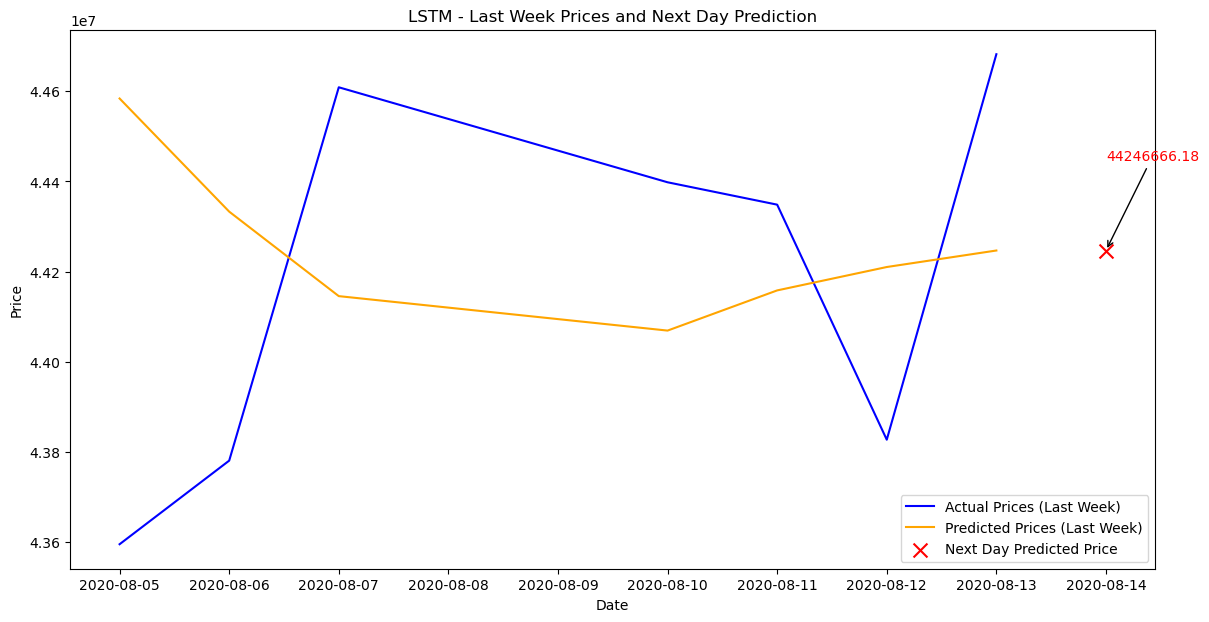

In [10]:
# ---- 마지막 일주일만 표시하는 그래프 ----
plt.figure(figsize=(14, 7))

# 마지막 일주일의 실제 가격 데이터 가져오기
last_week_actual = Y_test_actual[-7:, -1]  # 실제 가격 (Close 값)
last_week_dates = data.index[-7:]         # 마지막 7일의 날짜 인덱스

# 마지막 일주일의 예측 가격 가져오기
last_week_predicted = predicted_price[-7:]  # 예측 가격 (Close 값)

# 실제 가격 그래프
plt.plot(last_week_dates, last_week_actual, color='blue', label='Actual Prices (Last Week)')

# 예측 가격 그래프
plt.plot(last_week_dates, last_week_predicted, color='orange', label='Predicted Prices (Last Week)')

# 다음날 예측 가격
next_day_pred = model.predict(X_test[-1].reshape(1, time_step, len(features)))  # 마지막 테스트 샘플의 예측

# next_day_pred에 맞는 형태로 확장: 5개의 피처를 가진 배열로 만들어줍니다.
next_day_pred_full = np.hstack((np.zeros((next_day_pred.shape[0], 4)), next_day_pred))

# 예측 결과 역변환 (스케일 복원)
next_day_pred_full = scaler.inverse_transform(next_day_pred_full)

# 다음날 예측 가격만 추출
next_day_price = next_day_pred_full[0, -1]  # Close 값

# 예측된 다음날 가격의 날짜 설정
next_day_index = last_week_dates[-1] + pd.Timedelta(days=1)  # 마지막 날짜의 다음날

# 다음날 예측 가격을 그래프에 점으로 표시
plt.scatter(next_day_index, next_day_price, color='red', marker='x', s=100, label='Next Day Predicted Price')

# 다음날 예측 가격 주석 추가
plt.annotate(f'{next_day_price:.2f}', xy=(next_day_index, next_day_price), 
             xytext=(next_day_index, next_day_price + 0.02e7),
             arrowprops=dict(facecolor='black', arrowstyle='->'), fontsize=10, color='red')

# 제목, 라벨 설정
plt.title('LSTM - Last Week Prices and Next Day Prediction')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

# 그래프 출력
plt.show()
